In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 150

Деконструируем задачу следующим образом. Будем рассматривать независимо движение мины и наличие плоскогорья. Известно, что мина летит по параболе, которую зададим параметрически:
$$\begin{cases}x(t) & = & x_0 + v_0 \cos(\alpha t)\\
y(t) & = & y_0 + v_0 \sin(\alpha t) - gt^2/2\end{cases}$$
При этом в нашей задаче мы можем положить $y_0=0$.

Плато зададим как ступенчатую функцию от $x$:
$$h(x) = \begin{cases} 0, x < 0 \\
h, x > 0\end{cases}$$

In [2]:
def calc_x(v0, alpha, t, x0):
    return x0 + v0 * np.cos(alpha) * t


def calc_y(v0, alpha, t):
    return v0 * np.sin(alpha) * t - g * t ** 2 / 2


@np.vectorize
def plateau(h, x):
    return int(x > 0) * h

Зададим параметры моделирования <br>
    - `t_max` максимальное расчетное время, с <br>
    - `v0` начальная скорость мины, м/с <br>
    - `alpha` начальный угол наклонения миномета относительно горизонта, рад <br>
    - `x0` начальное положение миномета по оси $x$, м <br>
    - `g` ускорение свободного падения, $м/с^2$ <br>
    - `h` высота плоскогорья, м <br>

In [3]:
t_max = 1.5

v0 = 8
alpha = np.deg2rad(45)
x0 = -1

g = 9.8
h = 0.6

Будем искать решение задачи как максимальное значение второго корня $x_2$ уравнения:
$$v_0 \sin(\alpha t) - gt^2/2 = h$$
Эта задача является оптимизационной и решается методами минимизации функции потерь.
У уравнения 2 корня, и нам подходит только случай, когда $x_1<0,x_2>0$. Если $x_1 \ge 0$, то мина врежется в скальную стенку,
поэтому построим функцию потерь так, чтобы её значение при $x_1 \ge 0$ всегда были больше, чем при $x_1 < 0$. Кроме того, если $x_1 < 0$, то значение функции должно уменьшаться, если $x_2$ растет.
Такая функция строится как показано ниже

In [4]:
def opt_distance(params, v0, h, t_max):
    # Распаковка параметров (угол, начальное положение)
    alpha, x0 = params

    # Уравнение, корни которого мы ищем
    def root_fun(t):
        return calc_y(v0, alpha, t) - h

    # Нахождение корней (значений времени, когда y(t) = h)
    t_h1 = opt.root(root_fun, 0, method='hybr').x[0]
    t_h2 = opt.root(root_fun, t_max, method='hybr').x[0]
    # Нахождение соответствующих значений x
    x1 = calc_x(v0, alpha, t_h1, x0)
    x2 = calc_x(v0, alpha, t_h2, x0)
    
    if np.allclose(x1, x2):
        return calc_x(v0, alpha, t_max, x0)
    # Если x1 меньше нуля, то возвращаем -x2
    # Если x1 больше нуля, то возвращаем x2
    # При x1 меньше нуля при уменьшении -x2 растет x2, и минимум первого соответствует максимуму второго
    return x2 * np.sign(x1)

Так как функция потерь выпуклая (с одним минимумом), нелинейная и не дифференцируема в точке, где $x_1=0$, будем применять метод [Метод Нелдера-Мида](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9D%D0%B5%D0%BB%D0%B4%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%9C%D0%B8%D0%B4%D0%B0) с ограничениями (в нашем случае в прямоугольнике $\alpha\in[0,\pi/2],x_0\in[-\infty,0]$), реализованный в модуле `scipy.optimize`.

In [5]:
res = opt.minimize(opt_distance, [alpha, x0], args=(v0, h, t_max), 
                   #bounds=((0, np.pi / 2), (None, 0)), 
                   method='Nelder-Mead', tol=1e-14)
print(res)

 final_simplex: (array([[ 0.8777982 , -0.54440166],
       [ 0.8777982 , -0.54440166],
       [ 0.8777982 , -0.54440166]]), array([-5.33061224, -5.33061224, -5.33061224]))
           fun: -5.33061224489796
       message: 'Optimization terminated successfully.'
          nfev: 360
           nit: 180
        status: 0
       success: True
             x: array([ 0.8777982 , -0.54440166])


Для сравнения построим график полета мины с исходными параметрами и оптимизированными

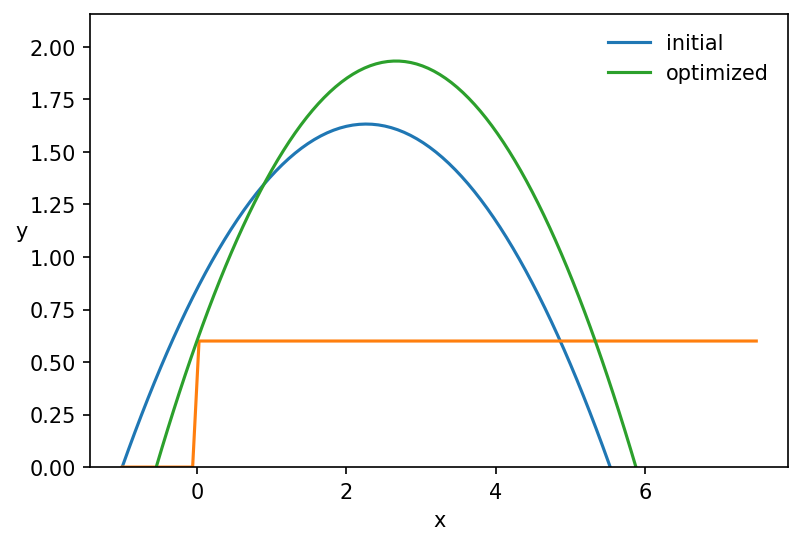

In [6]:
t = np.linspace(0, t_max, 100)
X = calc_x(v0, alpha, t, x0)

plt.plot(X, calc_y(v0, alpha, t), label='initial')
plt.plot(X, plateau(h, calc_x(v0, alpha, t, x0)))

alpha, x0 = res.x
X = calc_x(v0, alpha, t, x0)
plt.plot(X, calc_y(v0, alpha, t), label='optimized')

plt.ylim((0, None))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(frameon=False)
plt.show()

Сравним рассчитанные оптимальные значения с аналитически полученными результатами
$$x0=h(1-\eta+\sqrt{eta^2-1})$$
$$\alpha=\frac{1}{2}\arccos{\left(-\frac{1}{\eta}\right)}$$
Здесь $$\eta=\frac{v_0^2}{2gh}$$ отношение кинетической и потенциальной энергий.

In [11]:
eta = v0 ** 2 / 2 / g / h
alpha_t = 1 / 2 * np.arccos(- 1 / eta)
x0_t = h * (1 - eta + np.sqrt(eta ** 2 - 1))

print('Угол наклонения оптимальный', alpha, 'рад', 'теоретический', alpha_t, 'рад')
if np.allclose(alpha, alpha_t):
    print('Оптимальное значение угла совпадает с найденным теоретически.')
else:
    print('!Оптимальное значение угла не совпадает с найденным теоретически.')
print('Расстояние от обрыва оптимальное', -x0, 'м', 'теоретическое', x0_t, 'м')
if np.allclose(-x0, x0_t):
    print('Оптимальное значение расстояния от обрыва совпадает с найденным теоретически.')
else:
    print('!Оптимальное значение расстояния от обрыва не совпадает с найденным теоретически.')

Угол наклонения оптимальный 0.8777981989115697 рад теоретический 0.8777981925944375 рад
Оптимальное значение угла совпадает с найденным теоретически.
Расстояние от обрыва оптимальное 0.5444016562498907 м теоретическое 0.5444016638304491 м
Оптимальное значение расстояния от обрыва совпадает с найденным теоретически.


Для наглядности построим поверхность значений функции потерь `opt_distance` в пространстве параметров $\alpha, x_0$. В таком представлении хорошо видно, что функция потерь разрывная, поэтому методы, использующие градиенты функции могут давать некорректные результаты.

In [8]:
@np.vectorize
def show_x2(a, x):
    return opt_distance([a, x], v0, h, t_max)

alphas = np.linspace(0, np.pi / 2, 100).reshape((-1,1))
x0s = np.linspace(-4, 0, 100)

data = show_x2(alphas, x0s)

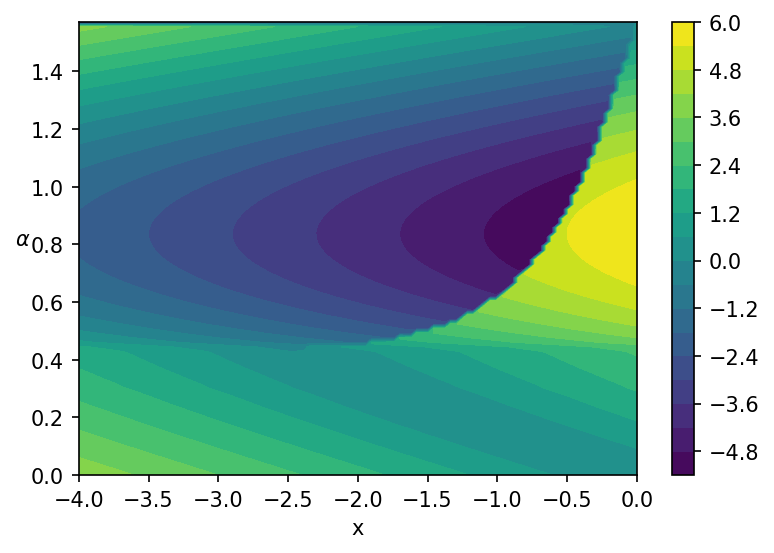

In [9]:
plt.contourf(data, extent=(-4, 0, 0, np.pi / 2), levels=20)
plt.xlabel('x')
plt.ylabel(r'$\alpha$', rotation=0)
plt.colorbar()
plt.show()